# Modelo incondicional Hugginface [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/chcomin/curso-visao-computacional-2024/blob/main/M11_geracao_de_imagens/2%20-%20Modelo%20incondicional%20hugginface%20\(GPU\).ipynb)

No notebook anterior implementamos um scheduler DDPM para geração incondicional de imagens. Veremos como usar o scheduler DDPM da biblioteca Hugginface.

### Pipeline Hugginface

A biblioteca Hugginface possui pipelines que facilitam a aplicação de modelos de difusão:

In [ ]:
import matplotlib.pyplot as plt
import torch
from diffusers import DiffusionPipeline

device = 'cuda'

# Opções de modelos:
#google/ddpm-church-256
#google/ddpm-celebahq-256
#google/ddpm-bedroom-256
repo_id = "google/ddpm-church-256"
pipeline = DiffusionPipeline.from_pretrained(repo_id).to(device)
generator = torch.Generator(device="cpu").manual_seed(0)  # o gerador é colocado na CPU de propósito
images = pipeline(num_inference_steps=50, generator=generator, batch_size=4).images

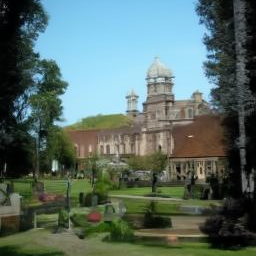

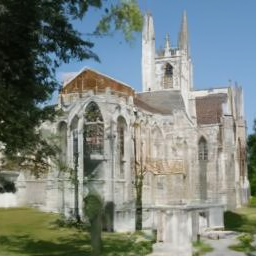

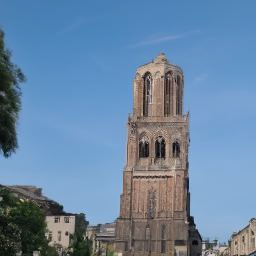

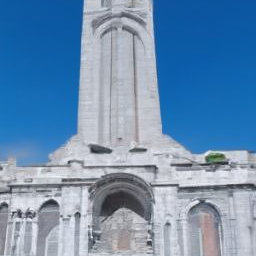

In [3]:
display(*images)

Todo pipeline do Hugginface possui o atributo config. Esse atributo descreve as classes dos componentes de um pipeline:

In [4]:
pipeline.config

FrozenDict([('unet', ('diffusers', 'UNet2DModel')),
            ('scheduler', ('diffusers', 'DDPMScheduler')),
            ('_name_or_path', 'google/ddpm-church-256')])

Vemos acima que o componente 'unet' do pipeline é a classe UNet2DModel e o scheduler é a classe DDPMScheduler

In [5]:
model = pipeline.unet
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

O modelo também possui um atributo config. Esse atributo pode ser utilizado para construir uma instância da classe UNet2DModel com os parâmetros específicos necessários para o pipeline

In [6]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('dropout', 0.0),
            ('act_fn', 'si

In [7]:
scheduler = pipeline.scheduler
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 0),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['timestep_spacing',
              'clip_sample_range',
              'sample_max_value',
              'dynamic_thresholding_ratio',
              'steps_offset',
              'rescale_betas_zero_snr',
              'thresholding',
              'prediction_type']),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_versi

O scheduler possui os valores de ruído que serão adicionados:

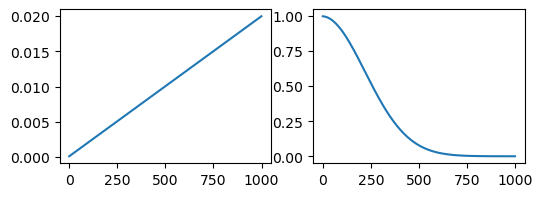

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6,2))
axs[0].plot(scheduler.betas)
axs[1].plot(scheduler.alphas_cumprod)

### Geração de imagens 

Vamos gerar uma imagem utilizando os componentes do pipeline ao invés de utilizar o pipeline diretamente

In [9]:
from diffusers import UNet2DModel, DDPMScheduler

model = UNet2DModel.from_pretrained("google/ddpm-church-256")
scheduler = DDPMScheduler.from_pretrained("google/ddpm-church-256")

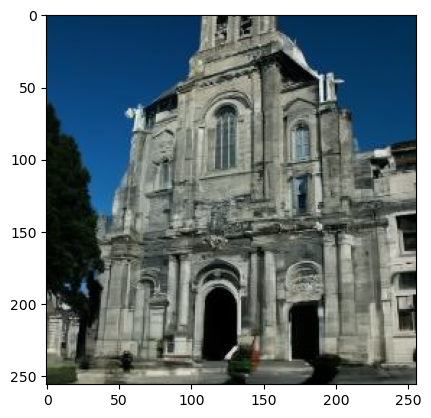

In [13]:
def generate(model, scheduler, n_steps):

    config = model.config

    scheduler.set_timesteps(n_steps)
    noisy_sample = torch.randn(1, config.in_channels, config.sample_size, config.sample_size)

    model.to(device)
    sample = noisy_sample.to(device)
    for step in scheduler.timesteps:
        with torch.no_grad():
            residual = model(sample, step).sample
        sample = scheduler.step(residual, step, sample).prev_sample

    return sample.cpu()

sample = generate(model, scheduler, 50)
sample = (sample[0].permute(1, 2, 0) + 1)/2
plt.imshow(sample)